<h1> Dora the explorer the pipeline </h1>

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

In [3]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import os

current_dir = os.getcwd()
print("Current working directory:", current_dir)


PATH = "/Users/matsalexander/Desktop/Forest Gump/"
# Estimate
X_train_estimated_a: pd.DataFrame = pd.read_parquet(
    PATH + 'A/X_train_estimated.parquet')
X_train_estimated_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_train_estimated.parquet")
X_train_estimated_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_train_estimated.parquet")

# Test estimates
X_test_estimated_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/X_test_estimated.parquet")
X_test_estimated_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_test_estimated.parquet")
X_test_estimated_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_test_estimated.parquet")

# Observations
X_train_observed_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/X_train_observed.parquet")
X_train_observed_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_train_observed.parquet")
X_train_observed_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_train_observed.parquet")

# Targets
Y_train_observed_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/train_targets.parquet")
Y_train_observed_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/train_targets.parquet")
Y_train_observed_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/train_targets.parquet")

test_df_example = pd.read_csv(PATH + "test.csv")

best_submission: pd.DataFrame = pd.read_csv(
    PATH + "mikael/submissions/fourth_submission.csv")

optins = {
    "randomize": False,
    "consecutive_threshold": 6,
    "normalize": False,
    "group_by_hour": True,
    "unzip_date_feature": True,
}

# make a options class with the options as attributes


class Options:
    randomize = False
    consecutive_threshold = 6
    normalize = False
    group_by_hour = True
    unzip_date_feature = True

    def __init__(self, randomize=False, consecutive_threshold=6, normalize=False, group_by_hour=True, unzip_date_feature=True) -> None:
        self.randomize = randomize
        self.consecutive_threshold = consecutive_threshold
        self.normalize = normalize
        self.group_by_hour = group_by_hour
        self.unzip_date_feature = unzip_date_feature


class Pipeline:

    def __init__(self):
        pass

    def get_combined_data(self, test_data=False):
        locations = ["A", "B", "C"]
        dfs = []
        for index, location in enumerate(locations):
            if test_data:
                dfs.append(self.get_test_data(location))
            else:
                dfs.append(self.get_data(location))

            dfs[index] = self.onehot_location(dfs[index], location)
        df = pd.concat(dfs).reset_index(drop=True)

        if test_data:
            return df
        return df[[c for c in df if c not in ['pv_measurement']] +  # pv measurement is the target and is at the end columns
                  ['pv_measurement']]

    def get_data(self, location: str, keeptime=False) -> pd.DataFrame:
        train, targets = self.get_training_data_by_location(location)
        return self.handle_data(train, targets, keeptime=keeptime)

    def get_test_data(self, location: str) -> pd.DataFrame:
        test_data = self.get_test_data_by_location(location)
        return self.handle_data(test_data)

    def handle_data(self, df, targets=pd.DataFrame(), keeptime=False):
        df["date_calc"] = pd.to_datetime(df["date_calc"])
        df["date_forecast"] = pd.to_datetime(df["date_forecast"])

        # df = self.add_time_since_calucation(df)
        df = self.onehot_estimated(df)
        df = self.unzip_date_feature(df)
        df = self.grouped_by_hour(df)

        df["time"] = df["date_forecast"]
        df.drop(["date_forecast"], axis=1, inplace=True)

        if not targets.empty:
            df = self.merge_train_target(df, targets)

        df.drop(columns=["time"], axis=1, inplace=True)

        df = self.absolute_values(df)
        return df

    # –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– helper funciton ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

    def get_training_data_by_location(self, location):
        if location == "A":
            X_train_observed_x = X_train_observed_a
            X_train_estimated_x = X_train_estimated_a
            Y_train_x = Y_train_observed_a
        elif location == "B":
            X_train_observed_x = X_train_observed_b
            X_train_estimated_x = X_train_estimated_b
            Y_train_x = Y_train_observed_b
        elif location == "C":
            X_train_observed_x = X_train_observed_c
            X_train_estimated_x = X_train_estimated_c
            Y_train_x = Y_train_observed_c
        else:
            raise Exception("location must be A, B or C")
        train = pd.concat(
            [X_train_observed_x, X_train_estimated_x]).reset_index(drop=True)
        return train, Y_train_x

    def get_test_data_by_location(self, location: str,  normalize=False) -> pd.DataFrame:
        if location == "A":
            df = X_test_estimated_a
        elif location == "B":
            df = X_test_estimated_b
        elif location == "C":
            df = X_test_estimated_c
        else:
            raise Exception("location must be A, B or C")
        return df.copy()

    def unzip_date_feature(self, df: pd.DataFrame, date_column: str = "date_forecast"):
        df[date_column] = pd.to_datetime(df[date_column])
        df["day_of_year"] = df["date_forecast"].dt.day_of_year
        df["hour"] = df["date_forecast"].dt.hour
        # df["month"] = df["date_forecast"].dt.month
        return df

    def add_time_since_calucation(self, df):  # denne er ikke så dum.
        df["date_calc"] = pd.to_datetime(df["date_calc"])
        df["calculated_ago"] = (
            df["date_forecast"] - df["date_calc"]).dt.total_seconds()
        df["calculated_ago"] = df["calculated_ago"].fillna(
            0) / 60/30
        return df

    def onehot_estimated(self, df):
        df["estimated"] = 0  # Initialize both columns to 0
        df["observed"] = 0
        estimated_mask = df["date_calc"].notna()
        df.loc[estimated_mask, "estimated"] = 1
        df.loc[~estimated_mask, "observed"] = 1
        return df

    def onehot_location(self, df, location):
        if location == "A":
            df["A"], df["B"], df["C"] = 1, 0, 0
        elif location == "B":
            df["A"], df["B"], df["C"] = 0, 1, 0
        elif location == "C":
            df["A"], df["B"], df["C"] = 0, 0, 1
        return df

    def grouped_by_hour(self, df: pd.DataFrame, date_column: str = "date_forecast"):
        df = df.groupby(pd.Grouper(key=date_column, freq="1H")
                        ).mean(numeric_only=True)
        all_nan_mask = df.isnull().all(axis=1)
        df = df[~all_nan_mask]
        return df.reset_index()

    def merge_train_target(self, x, y):
        # henning får med alle pv measurments selv om han merger på inner time. Fordi resample fyller nan rows for alle timer som ikke er i datasettet.
        merged = pd.merge(x, y, on="time", how="right")
        mask = merged["pv_measurement"].notna()
        merged = merged.loc[mask].reset_index(drop=True)
        return merged

    def absolute_values(self, df: pd.DataFrame):
        columns = list(df.columns)
        df[columns] = df[columns].abs()
        df = df.replace(-0.0, 0.0)
        return df

    def lag_features_by_1_hour(df, columns_to_lag):
        lag_columns = [c for c in df.columns if "_1h:" in c]
        df[lag_columns] = df[lag_columns].shift(1)
        return df

    def remove_consecutive_measurments_new(self, df: pd.DataFrame, consecutive_threshold=3, consecutive_threshold_zero=12, return_removed=False):
        if consecutive_threshold < 2:
            return df

        column_to_check = 'pv_measurement'

        mask = (df[column_to_check] != df[column_to_check].shift(1)).cumsum()
        df['consecutive_group'] = df.groupby(
            mask).transform('count')[column_to_check]

        df["is_first_in_consecutive_group"] = False
        df['is_first_in_consecutive_group'] = df['consecutive_group'] != df['consecutive_group'].shift(
            1)

        # masks to remove rows
        mask_non_zero = (df['consecutive_group'] >= consecutive_threshold) & (
            df["pv_measurement"] > 0) & (df["is_first_in_consecutive_group"] == False)  # or df["direct_rad:W"] == 0)

        mask_zero = (df['consecutive_group'] >= consecutive_threshold_zero) & (
            df["pv_measurement"] == 0) & (df["is_first_in_consecutive_group"] == False)

        mask = mask_non_zero | mask_zero

        if return_removed:
            return df[mask]

        df = df.loc[~mask]

        df = df.drop(columns=["consecutive_group",
                     "is_first_in_consecutive_group"])

        return df.reset_index(drop=True)

    def remove_consecutive_measurments_new_new(self, df: pd.DataFrame, consecutive_threshold=3, consecutive_threshold_zero=12, consecutive_threshold_zero_no_rad=20, return_removed=False):
        if consecutive_threshold < 2:
            return df

        column_to_check = 'pv_measurement'

        mask = (df[column_to_check] != df[column_to_check].shift(1)).cumsum()
        df['consecutive_group'] = df.groupby(
            mask).transform('count')[column_to_check]

        df["is_first_in_consecutive_group"] = False
        df['is_first_in_consecutive_group'] = df['consecutive_group'] != df['consecutive_group'].shift(
            1)

        # masks to remove rows
        mask_non_zero = (df['consecutive_group'] >= consecutive_threshold) & (
            df["pv_measurement"] > 0) & (df["is_first_in_consecutive_group"] == False)  # or df["direct_rad:W"] == 0)

        tol = 10
        mask_zero = (df['consecutive_group'] >= consecutive_threshold_zero) & (
            df["pv_measurement"] == 0) & (df["direct_rad:W"] > tol)

        mask_zero_no_rad = (df['consecutive_group'] >= consecutive_threshold_zero_no_rad) & (
            df["pv_measurement"] == 0) & (df["direct_rad:W"] < tol)
        mask = mask_non_zero | mask_zero | mask_zero_no_rad

        if return_removed:
            return df[mask]

        df = df.loc[~mask]

        df = df.drop(columns=["consecutive_group",
                     "is_first_in_consecutive_group"])

        return df.reset_index(drop=True)

    def compare_mae(self, df: pd.DataFrame):
        best_submission: pd.DataFrame = pd.read_csv(
            PATH+"mats/submissions/gluon_3_remove_consecutive_measurements_66.csv")
        best_submission = best_submission[["prediction"]]

        if best_submission.shape != df.shape:
            print("best_submission", best_submission.shape)
            print("df", df.shape)
            raise Exception("Dataframe shape must be the same")

        return mean_absolute_error(
            best_submission["prediction"], df["prediction"])

    def split_train_tune(self, df: pd.DataFrame):
        df = df.copy()
        df_estimated = df.loc[df["estimated"] == 1]
        df_observed = df.loc[df["estimated"] == 0]

        num_rows = len(df_estimated)
        middle_index = num_rows // 2

        df_estimated.sample(frac=1, random_state=42)
        train_estimated = df_estimated.iloc[:middle_index]
        tune = df_estimated.iloc[middle_index:]

        train = pd.concat([df_observed, train_estimated])
        return train, tune

    def drop_columns(self, df: pd.DataFrame):
        drop = [
            # wind speed vector u, available up to 20000 m, from 1000 hPa to 10 hPa and on flight levels FL10-FL900[m/s] does not make sens at surfece level
            "wind_speed_w_1000hPa:ms",
            "wind_speed_u_10m:ms",  # same as above
            "wind_speed_v_10m:ms",  # same as above
            # "snow_drift:idx",
            # "snow_density:kgm3",
            # "snow_melt_10min:mm",  # veldig få verdier
        ]
        shared_columns = list(set(df.columns) & set(drop))
        df = df.drop(columns=shared_columns)
        return df

    def drop_columns_new(self, df: pd.DataFrame):
        drop = [
            # wind speed vector u, available up to 20000 m, from 1000 hPa to 10 hPa and on flight levels FL10-FL900[m/s] does not make sens at surfece level
            "wind_speed_w_1000hPa:ms",
            "wind_speed_u_10m:ms",  # same as above
            "wind_speed_v_10m:ms",  # same as above
            "snow_drift:idx",
            "snow_density:kgm3",
            # "snow_melt_10min:mm",  # veldig få verdier
        ]
        shared_columns = list(set(df.columns) & set(drop))
        df = df.drop(columns=shared_columns)
        return df

    def find_min_max_date_in_test(self) -> list:
        locations = ["A", "B", "C"]
        dates = []
        for loc in locations:
            df = self.get_test_data_by_location(loc)
            df["date_forecast"] = pd.to_datetime(df["date_forecast"])
            dates.append((df["date_forecast"].min(),
                         df["date_forecast"].max()))
        return dates

    def split_train_summer_2021(self, df: pd.DataFrame):
        dates = self.find_min_max_date_in_test()
        # set the dates to the summer of 2021
        dates = [(date[0].replace(year=2021), date[1].replace(year=2021))
                 for date in dates]

        summer2021 = df[(df["date_forecast"] >= dates[0][0]) & (
            df["date_forecast"] <= dates[0][1])]

        train = df[~df.index.isin(summer2021.index)]
        return train, summer2021

    def post_processing(self, df: pd.DataFrame, prediction_column: str = "prediction_label"):
        df = df[[prediction_column]].rename(
            columns={prediction_column: "prediction"}).reset_index(drop=True).rename_axis(index="id")

        df["prediction"] = df["prediction"].clip(lower=0)
        return df

Current working directory: /Users/matsalexander/Desktop/Forest Gump/final_submission/mats_explore_to_merge


In [ ]:
pipe = Pipeline()

In [4]:
# all_data = pipe.get_combined_datasets(offset_years=True)
all_data = pipe.get_combined_data()
df0 = all_data

Se på features

In [5]:
snow_features = [c  for c in all_data.columns if 'snow' in c]
snow_features
all_data[snow_features].describe()

,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2
count,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,4213.0,92951.000000,92951.000000,92951.000000,92951.000000
mean,0.117096,0.009727,0.231608,0.029244,0.058533,250.0,0.193164,0.000022,0.000273,0.090299
std,0.779764,0.104943,1.223007,0.275208,0.477040,0.0,1.253925,0.004181,0.004249,0.237841
min,0.000000,0.000000,0.000000,0.000000,0.000000,250.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,250.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,250.0,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,250.0,0.000000,0.000000,0.000000,0.100000
max,37.474998,7.250000,37.474998,20.325001,33.375000,250.0,18.200001,1.000000,0.180000,5.650000


In [6]:
for sne_feat in snow_features:
    sne_sum = all_data[sne_feat].sum()
    print(f'{sne_feat} : {sne_sum} ')

fresh_snow_12h:cm : 10884.2001953125 
fresh_snow_1h:cm : 904.1250610351562 
fresh_snow_24h:cm : 21528.17578125 
fresh_snow_3h:cm : 2718.25 
fresh_snow_6h:cm : 5440.69970703125 
snow_density:kgm3 : 1053250.0 
snow_depth:cm : 17954.826171875 
snow_drift:idx : 2.0 
snow_melt_10min:mm : 25.399999618530273 
snow_water:kgm2 : 8393.375 


In [7]:
sum_snow_drift = all_data['snow_drift:idx'].unique()
print(sum_snow_drift)
print( all_data['snow_drift:idx'].sum())

[0.    nan 0.75 1.   0.25]
2.0


<h1>Se på tune funcksjonen. Hva gjør den? <h1>

In [8]:
df1_0 = pipe.get_data("A")
df2_0 = pipe.get_data("B")
df3_0 = pipe.get_data("C") 

In [9]:
train1, tune1 = pipe.split_train_tune(df1_0 )
train2, tune2 = pipe.split_train_tune(df2_0 )
train3, tune3 = pipe.split_train_tune(df3_0 )  

In [10]:
df1_0.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,observed,day_of_year,hour,pv_measurement
count,34061.000000,34061.000000,27934.000000,3.406100e+04,34061.000000,31698.000000,34061.00000,34061.000000,34061.000000,3.406100e+04,34061.000000,3.406100e+04,34061.000000,34061.0,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,1140.0,34061.000000,34061.0,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34085.000000
mean,6.322320,1.253280,2974.149414,5.526711e+05,153.519684,1728.923462,0.03777,275.971802,42.069969,1.514517e+05,52.627697,1.894599e+05,67.701607,6.0,0.088203,0.007403,0.173595,0.022289,0.044405,0.499185,0.535348,1009.603821,0.006015,0.089075,996.707581,1002.829041,0.231885,0.010783,74.025368,1008.977905,250.0,0.073509,0.0,0.000127,0.089688,179.636734,19.554213,0.055665,279.936371,74.319000,32577.396484,3.061313,2.343175,1.519751,0.000017,0.129004,0.870996,183.672176,11.500954,630.594707
std,2.799442,0.037206,2564.641846,8.483389e+05,236.244736,1807.137817,0.18258,6.892324,62.838524,2.235248e+05,115.250557,4.093454e+05,33.808254,0.0,0.594526,0.083636,0.928176,0.214113,0.366713,0.486157,0.486656,12.739138,0.030218,0.323689,12.603231,12.659498,2.803257,0.043945,13.881201,12.717940,0.0,0.468488,0.0,0.002649,0.237548,97.657913,14.180796,0.103919,6.664930,33.492355,17701.937500,1.774981,1.814351,1.179184,0.001157,0.335209,0.335209,106.316505,6.923089,1165.902422
min,0.700000,1.145000,27.849998,0.000000e+00,0.000000,27.799999,0.00000,251.074997,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.400024,0.000000,0.000000,932.400024,938.200012,0.000000,0.000000,21.700001,944.000000,250.0,0.000000,0.0,0.000000,0.000000,6.983000,0.000500,0.000000,259.000000,0.000000,159.675003,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4.200000,1.227500,1126.050049,0.000000e+00,0.000000,582.918762,0.00000,271.299988,0.000000,0.000000e+00,0.000000,0.000000e+00,43.500000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.650024,0.000000,0.000000,988.875000,994.950012,0.000000,0.000000,64.750000,1001.075012,250.0,0.000000,0.0,0.000000,0.000000,94.178497,7.023500,0.000000,275.225006,54.549999,16580.625000,1.675000,0.950000,0.600000,0.000000,0.000000,1.000000,89.000000,6.000000,0.000000
50%,5.800000,1.251500,1978.900024,2.166182e+04,3.525000,1150.162476,0.00000,276.000000,2.075000,1.651862e+04,0.000000,1.248000e+02,80.449997,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1010.549988,0.000000,0.000000,997.700012,1003.775024,0.000000,0.000000,76.400002,1009.900024,250.0,0.000000,0.0,0.000000,0.000000,180.045746,17.074001,0.000000,279.549988,93.500000,35903.824219,2.725000,1.900000,1.250000,0.000000,0.000000,1.000000,186.000000,12.000000,5.940000
75%,8.250000,1.277250,4174.150391,8.924273e+05,251.925003,2084.781250,0.00000,281.349976,70.699997,2.536671e

In [11]:

tune1.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,observed,day_of_year,hour,pv_measurement
count,2197.000000,2197.000000,1694.000000,2.197000e+03,2197.000000,1909.000000,2197.000000,2197.000000,2197.000000,2.197000e+03,2197.000000,2.197000e+03,2197.000000,2197.0,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,150.0,2197.000000,2197.0,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.0,2197.0,2197.0,2197.000000,2197.000000,2197.000000
mean,4.116796,1.281070,3213.755615,4.409714e+05,122.473030,1637.790771,0.038917,270.453186,40.571609,1.460680e+05,48.508091,1.746288e+05,68.099396,6.0,0.390009,0.030291,0.779097,0.094083,0.192126,0.475535,0.558603,1011.370605,0.003957,0.085913,998.234741,1004.483398,0.668025,0.001218,71.027733,1010.759888,250.0,0.166545,0.0,0.000632,0.079381,179.904572,17.712051,0.034160,274.818512,72.876511,29622.638672,3.335924,2.670722,1.559877,0.0,1.0,0.0,74.727811,11.532544,590.297651
std,1.319260,0.024972,2486.944092,6.646809e+05,185.306503,1836.614136,0.187007,4.745133,58.202454,2.065653e+05,106.050629,3.769525e+05,36.833477,0.0,1.172899,0.151295,1.935587,0.402777,0.696882,0.486438,0.483631,14.432036,0.018353,0.387928,14.331497,14.380436,4.924515,0.010667,14.558252,14.429879,0.0,0.719369,0.0,0.006709,0.197618,96.680031,11.031183,0.083005,3.974071,36.785950,14608.264648,1.908954,1.989711,1.102087,0.0,0.0,0.0,26.432590,6.922118,1166.894573
min,1.100000,1.220750,27.924999,0.000000e+00,0.000000,28.200001,0.000000,255.250000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,973.200012,0.000000,0.000000,960.674988,966.650024,0.000000,0.000000,21.700001,972.650024,250.0,0.000000,0.0,0.000000,0.000000,14.913000,0.022500,0.000000,261.975006,0.000000,1352.199951,0.125000,0.000000,0.000000,0.0,1.0,0.0,29.000000,0.000000,0.000000
25%,3.200000,1.264500,1175.968750,0.000000e+00,0.000000,527.775024,0.000000,267.700012,0.000000,0.000000e+00,0.000000,0.000000e+00,37.349998,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.500000,0.000000,0.000000,988.450012,994.699951,0.000000,0.000000,61.450001,1000.949951,250.0,0.000000,0.0,0.000000,0.000000,95.153000,8.690750,0.000000,272.424988,46.250000,18605.449219,1.800000,1.000000,0.650000,0.0,1.0,0.0,52.000000,6.000000,0.000000
50%,4.225000,1.280500,2653.800049,9.454175e+03,0.950000,903.150024,0.000000,271.424988,0.575000,1.431685e+04,0.000000,0.000000e+00,87.625000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,1.000000,1010.549988,0.000000,0.000000,997.400024,1003.625000,0.000000,0.000000,73.449997,1009.950012,250.0,0.000000,0.0,0.000000,0.000000,179.470505,16.332750,0.000000,274.849976,96.849998,30314.824219,3.000000,2.275000,1.400000,0.0,1.0,0.0,75.000000,12.000000,1.320000
75%,5.000000,1.296000,4572.125000,7.225884e+05,202.225006,1932.900024,0.000000,273.799988,75.074997,2.670561e+05,30.325001,1.145617e+05,99.900002,6.0,0.000000,0.000000,0.075000,0.000000,0.000000,1.000000,1.000000,1022.650024,0.000000,0.0000

In [12]:
train1.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,observed,day_of_year,hour,pv_measurement
count,31864.000000,31864.000000,26240.000000,3.186400e+04,31864.000000,29789.000000,31864.000000,31864.000000,31864.000000,3.186400e+04,31864.000000,3.186400e+04,31864.000000,31864.0,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,990.0,31864.000000,31864.0,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000,31864.000000
mean,6.474390,1.251364,2958.680420,5.603728e+05,155.660339,1734.763550,0.037691,276.352356,42.173279,1.518229e+05,52.911743,1.904825e+05,67.674187,6.0,0.067393,0.005825,0.131846,0.017339,0.034220,0.500816,0.533745,1009.481995,0.006157,0.089294,996.602295,1002.715027,0.201814,0.011442,74.232048,1008.854980,250.0,0.067094,0.0,0.000093,0.090399,179.618271,19.681231,0.057148,280.289246,74.418465,32781.121094,3.042379,2.320591,1.516984,0.000018,0.068949,0.931051,191.183812,11.498776,633.818333
std,2.810473,0.037147,2568.855469,8.590304e+05,239.211639,1805.106812,0.182274,6.854417,63.145176,2.246452e+05,115.854111,4.114707e+05,33.590080,0.0,0.525649,0.076557,0.797296,0.193507,0.329654,0.486103,0.486830,12.605176,0.030863,0.318789,12.468612,12.524339,2.591273,0.045274,13.809577,12.582287,0.0,0.445321,0.0,0.002092,0.240042,97.726456,14.363981,0.105047,6.668221,33.251568,17877.751953,1.763827,1.799469,1.184281,0.001196,0.253372,0.253372,105.639081,6.923259,1166.124516
min,0.700000,1.145000,27.849998,0.000000e+00,0.000000,27.799999,0.000000,251.074997,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.400024,0.000000,0.000000,932.400024,938.200012,0.000000,0.000000,22.700001,944.000000,250.0,0.000000,0.0,0.000000,0.000000,6.983000,0.000500,0.000000,259.000000,0.000000,159.675003,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4.300000,1.226000,1122.637573,0.000000e+00,0.000000,588.650024,0.000000,271.600006,0.000000,0.000000e+00,0.000000,0.000000e+00,43.718749,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.650024,0.000000,0.000000,988.900024,994.950012,0.000000,0.000000,64.949997,1001.075012,250.0,0.000000,0.0,0.000000,0.000000,94.122498,6.902813,0.000000,275.549988,54.943748,16383.868896,1.675000,0.925000,0.600000,0.000000,0.000000,1.000000,102.000000,5.000000,0.000000
50%,6.075000,1.249000,1950.875000,2.294212e+04,3.750000,1164.025024,0.000000,276.600006,2.150000,1.662506e+04,0.000000,1.473375e+02,80.050003,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1010.549988,0.000000,0.000000,997.700012,1003.799988,0.000000,0.000000,76.649994,1009.900024,250.0,0.000000,0.0,0.000000,0.000000,180.081123,17.169375,0.000000,280.100006,93.224998,36397.400391,2.700000,1.900000,1.250000,0.000000,0.000000,1.000000,198.000000,11.000000,6.600000
75%,8.425000,1.275000,4136.362793,9.037950e+05,257.500008,2088.524902,0.000000,281.649994,70.525002,2.

Hva gjør remove consec

In [13]:
# Test estimates
X_test_estimated_a = pd.read_parquet("../A/X_test_estimated.parquet")
X_test_estimated_b = pd.read_parquet("../B/X_test_estimated.parquet")
X_test_estimated_c = pd.read_parquet("../C/X_test_estimated.parquet")

# train Estimate
X_train_estimated_a = pd.read_parquet("../A/X_train_estimated.parquet")
X_train_estimated_b = pd.read_parquet("../B/X_train_estimated.parquet")
X_train_estimated_c = pd.read_parquet("../C/X_train_estimated.parquet")

# Observations
X_train_observed_a = pd.read_parquet("../A/X_train_observed.parquet")
X_train_observed_b = pd.read_parquet("../B/X_train_observed.parquet")
X_train_observed_c = pd.read_parquet("../C/X_train_observed.parquet")

# Targets
y_a = pd.read_parquet("../A/train_targets.parquet")
y_b = pd.read_parquet("../B/train_targets.parquet")
y_c = pd.read_parquet("../C/train_targets.parquet")

# X_test_estimated_b.describe()
X_train_estimated_c.head()

FileNotFoundError: [Errno 2] No such file or directory: '../A/X_test_estimated.parquet'

In [ ]:
feature_name = "pv_measurement"
all_data['time'] = pd.to_datetime(all_data['time'])
plt.figure(figsize=(20, 10))
plt.plot(all_data['time'], all_data[feature_name], marker='o', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Energy Measurement')
plt.title('Energy Measurement Over Time')
plt.grid(True)
plt.show()


KeyError: 'time'

<h5> The sampling device seems to be broken in the interval below

(40, 53)


/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_69843/3032346376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['time'] = pd.to_datetime(sub_data['time'])


Text(0.5, 0, 'Timestamp')

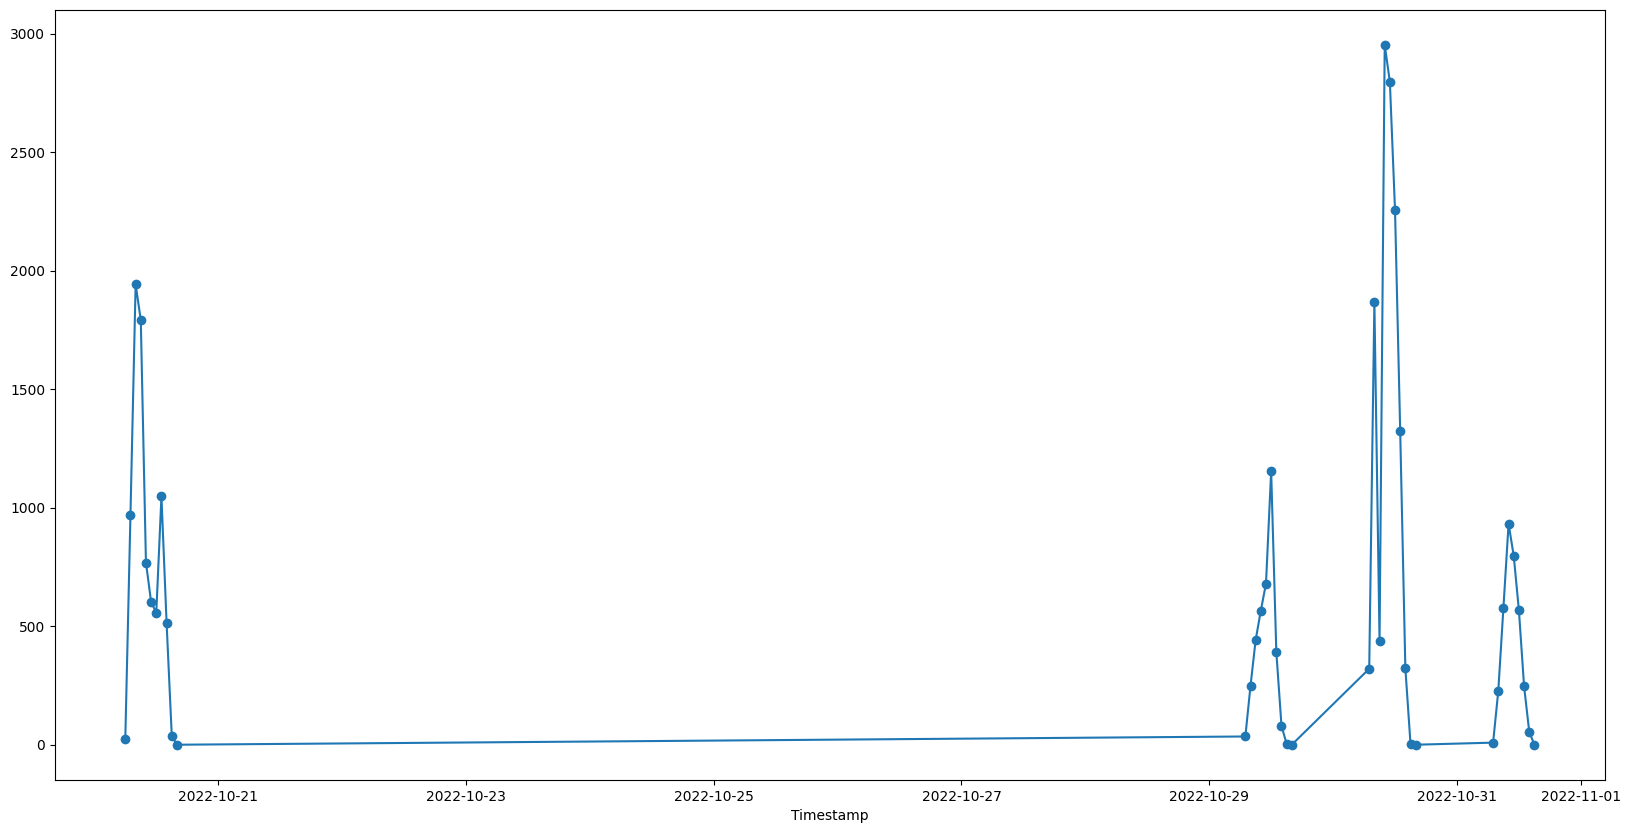

In [ ]:
# select the data frames from 2020-06 to 2020-09
feature_name = "pv_measurement"
start_date = '2022-10-20'
end_date = '2022-11-01'


mask = (all_data['time'] > start_date) & (all_data['time'] <= end_date)
sub_data = all_data.loc[mask]
sub_data['time'] = pd.to_datetime(sub_data['time'])
print(sub_data.shape)
plt.figure(figsize=(20, 10))
plt.plot(sub_data['time'], sub_data[feature_name], marker='o', linestyle='-')
plt.xlabel('Timestamp')
# sub_data[['time', "pv_measurement"]]


In [ ]:

# for index, row in enumerate(y_b_sub.values):
#     value = row[1]
#     last_10_values = y_b_sub.iloc[index-10:index, 1].values
#     # if np.all(last_10_values == value) and index > 10:
#     #     print(row[0], last_10_values) 
#     if value == 183.7125:
#         print(row[0], row[1])

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

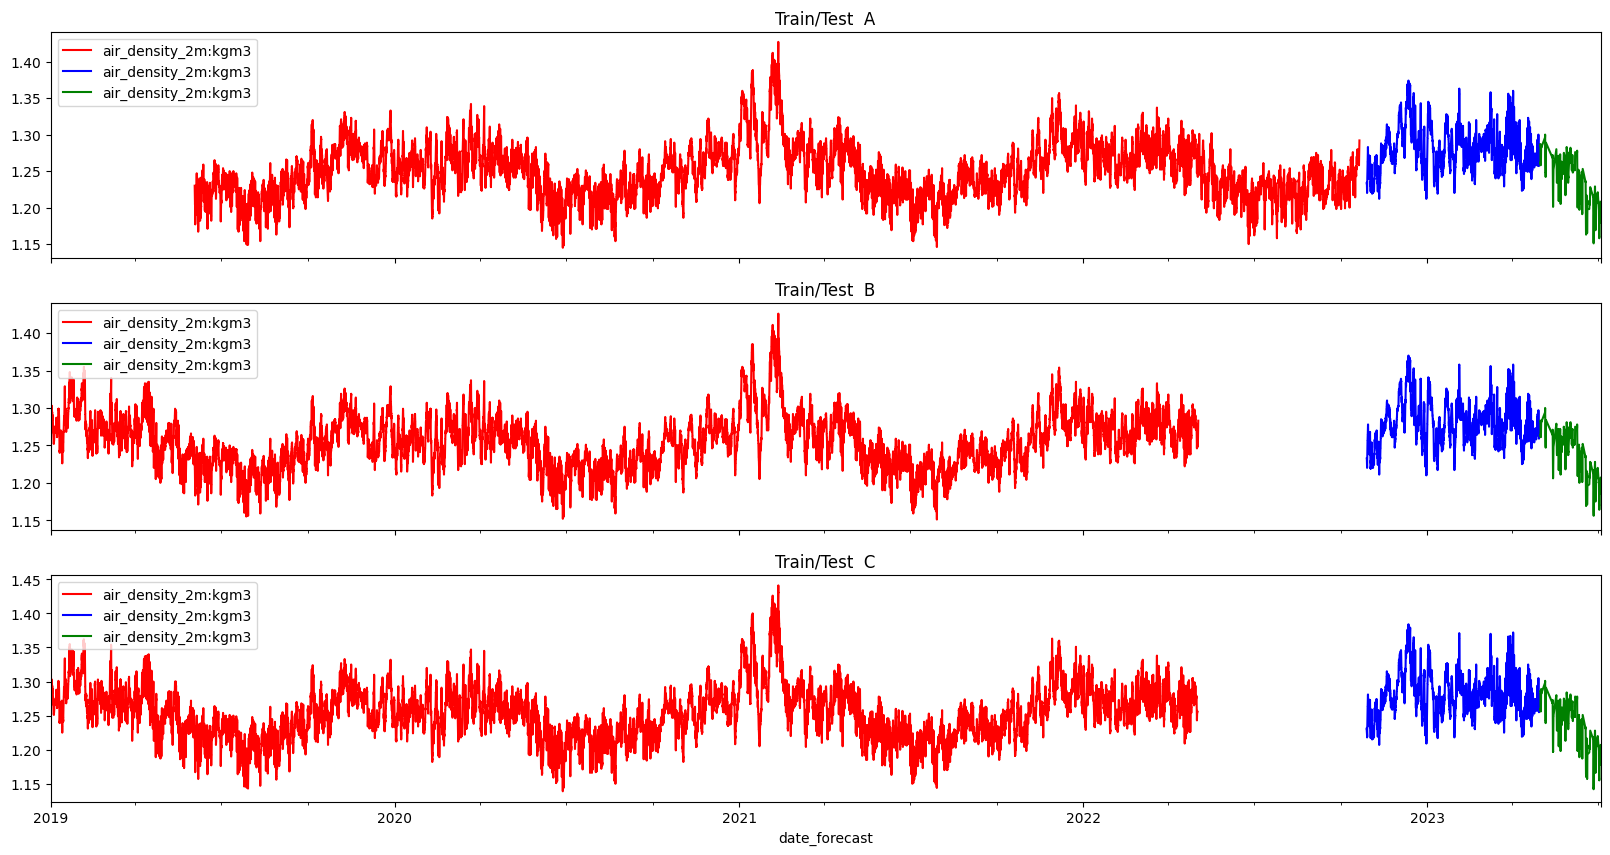

In [ ]:
feature_names = X_train_observed_a.columns
# X_train_observed_a["date_forecast"] = pd.to_datetime(X_train_observed_a["date_forecast"])
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = feature_names[2]
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')


In [ ]:
feature_names

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

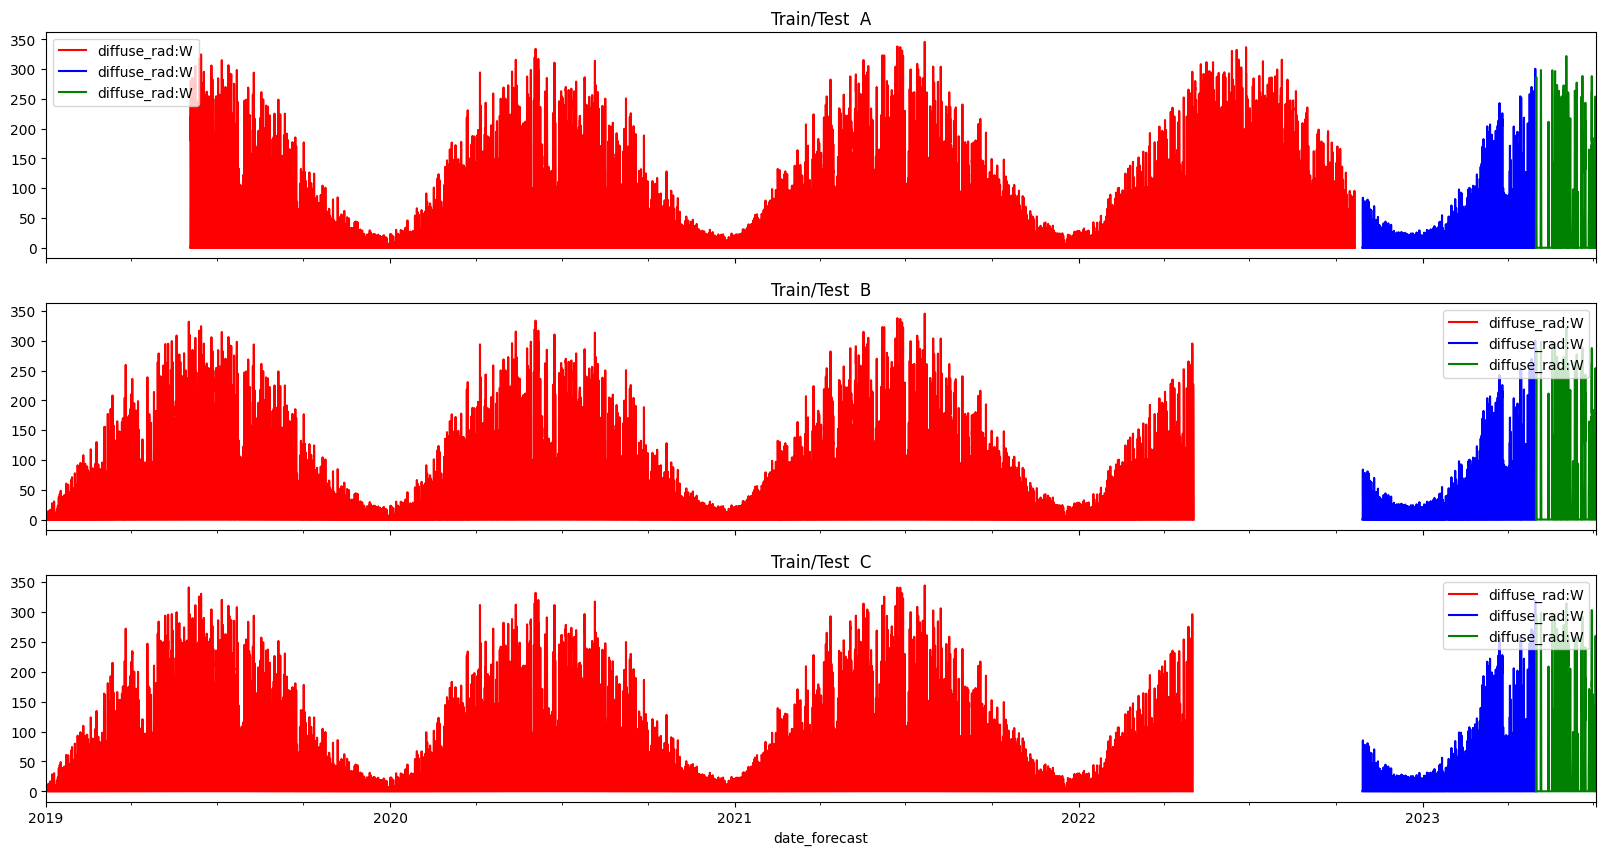

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = feature_names[2]
feature_name = "diffuse_rad:W"
# feature_name = "sun_azimuth:d"

X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')


In [ ]:
feature_names

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

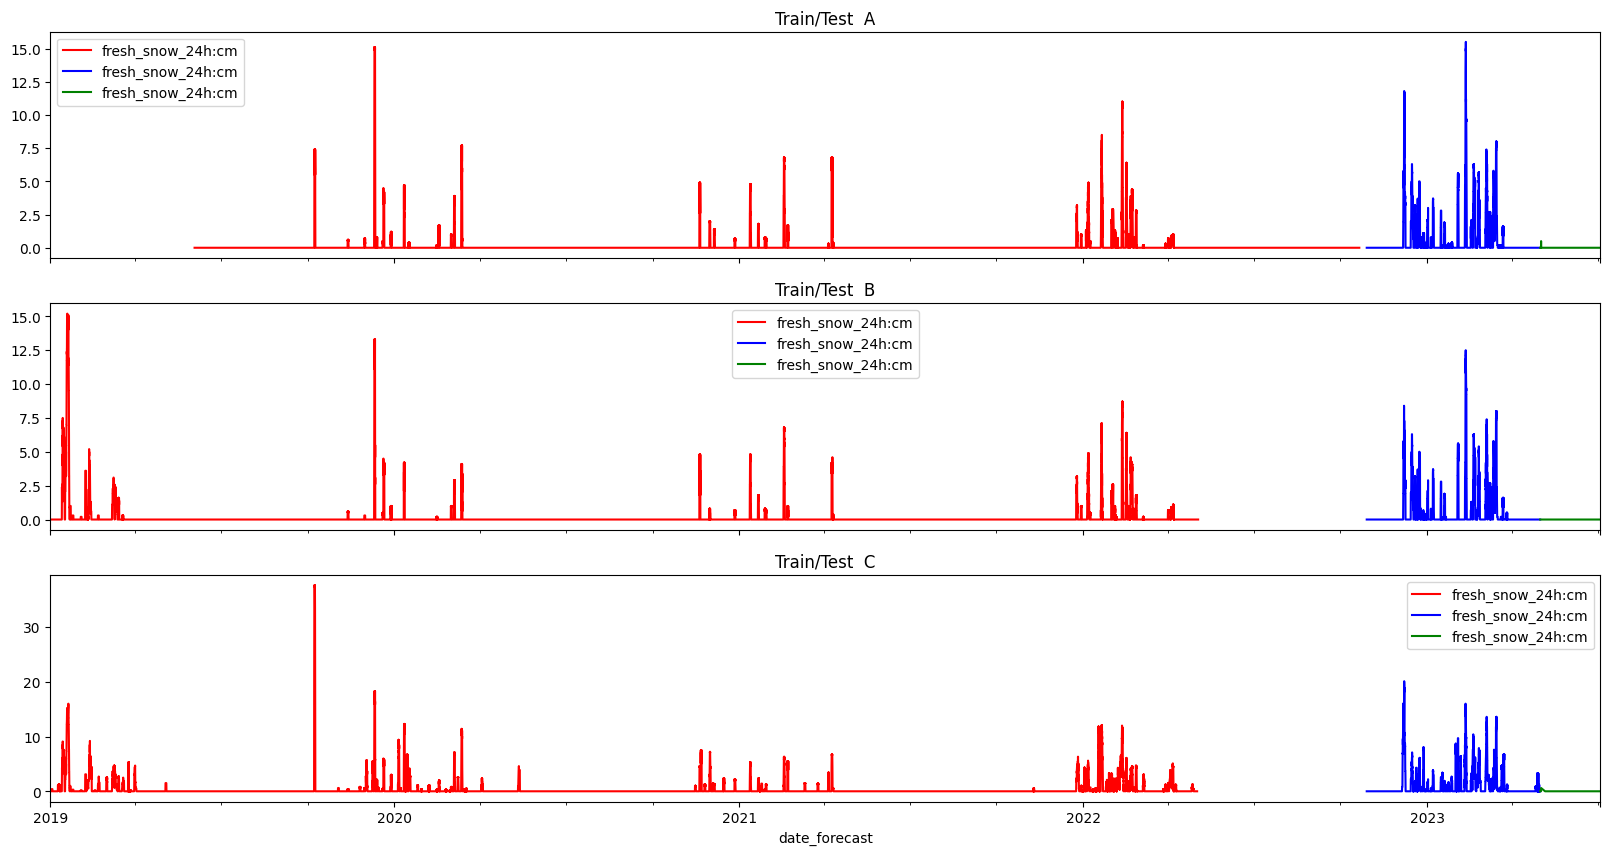

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = "sun_azimuth:d"
feature_name = "fresh_snow_24h:cm"

X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')
